In [1]:
import sys
sys.path.append('src')

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dropout
from scipy.signal import savgol_filter
from keras.optimizers import Adam
import scipy.stats as stats


In [4]:
from ppopt.plot import parametric_plot
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm
from ppopt.mplp_program import MPLP_Program
from ppopt.mpqp_program import MPQP_Program
import sympy
from energiapy.components import *
from energiapy.model.solve import solve
from energiapy.plot import *
from energiapy.model.formulate import formulate, Constraints, Objective, ModelClass
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.utils.math_utils import normalize, min_max
from itertools import product
from matplotlib import rc

In [5]:
# df = pandas.read_csv('../data/ercot.csv')
df = pandas.read_csv('ercot.csv')

df['Datetime'] = pandas.to_datetime(df['Unnamed: 0'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('Datetime')
df = df.resample('D').mean()
df

C:\Users\cacodcar\AppData\Local\Temp\ipykernel_5440\3242755214.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Datetime'] = pandas.to_datetime(df['Unnamed: 0'])


,COAST
Datetime,
2016-01-01,9733.736857
2016-01-02,9967.949162
2016-01-03,9409.771088
2016-01-04,10257.882329
2016-01-05,10532.679773
...,...
2020-12-27,10252.197429
2020-12-28,10735.672388
2020-12-29,10741.396777


<Axes: xlabel='Datetime'>

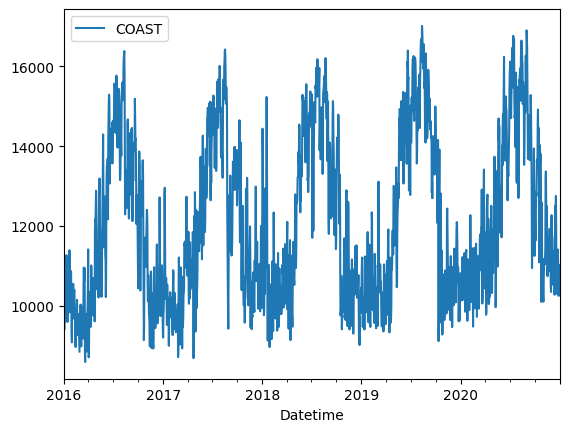

In [6]:
df.plot()

<Axes: xlabel='Datetime'>

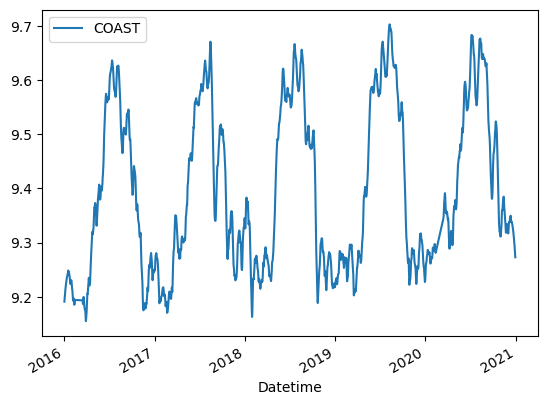

In [7]:
window_size = 30
polynomial_degree = 2
smoothed_data = savgol_filter(df['COAST'], window_size, polynomial_degree)
filtered_data = pandas.DataFrame({'COAST': smoothed_data}, index=df.index)
filtered_data['COAST'] = np.log(filtered_data['COAST'])
filtered_data = filtered_data.dropna()
filtered_data.plot()

In [8]:
 # convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

data = filtered_data.values
dataset=data.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 150
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

learning_rate = 0.0005
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dropout(0.10))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

history = model.fit(trainX, trainY, epochs=500, batch_size=240, verbose=1, validation_data=(testX, testY))


Epoch 1/500

5/5 [==============================] - 2s 121ms/step - loss: 0.1190 - val_loss: 0.0695
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0706 - val_loss: 0.0244
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 0.0291 - val_loss: 0.0330
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 0.0277 - val_loss: 0.0251
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0186 - val_loss: 0.0115
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0179 - val_loss: 0.0094
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0128 - val_loss: 0.0141
Epoch 8/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0127 - val_loss: 0.0111
Epoch 9/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0110 - val_loss: 0.0065
Epoch 10/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0115 - val_loss: 0.0075
Epoch 11/500
5/5

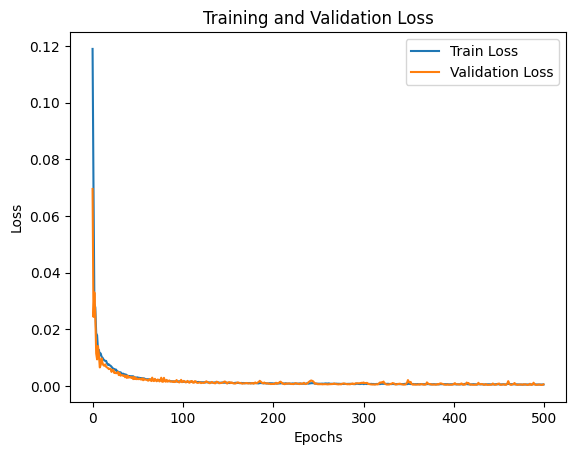

In [9]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

12/12 [==============================] - 0s 2ms/step
Train Score: 97.57 RMSE
Test Score: 163.08 RMSE
testPredictions:
[[10689.657 ]
 [10631.879 ]
 [10559.791 ]
 [10502.513 ]
 [10459.014 ]
 [10423.296 ]
 [10374.821 ]
 [10331.939 ]
 [10254.763 ]
 [10169.197 ]
 [10112.958 ]
 [10135.474 ]
 [10234.079 ]
 [10333.073 ]
 [10405.8955]
 [10457.259 ]
 [10479.541 ]
 [10467.396 ]
 [10438.815 ]
 [10433.729 ]
 [10474.746 ]
 [10554.434 ]
 [10620.853 ]
 [10701.877 ]
 [10827.811 ]
 [10982.644 ]
 [11074.398 ]
 [11073.216 ]
 [11037.791 ]
 [10998.513 ]
 [10936.27  ]
 [10908.623 ]
 [10880.778 ]
 [10843.363 ]
 [10796.413 ]
 [10734.238 ]
 [10640.684 ]
 [10528.186 ]
 [10452.184 ]
 [10403.088 ]
 [10360.722 ]
 [10324.147 ]
 [10250.763 ]
 [10171.932 ]
 [10117.569 ]
 [10112.9   ]
 [10152.907 ]
 [10235.709 ]
 [10331.545 ]
 [10432.088 ]
 [10491.542 ]
 [10544.3125]
 [10588.309 ]
 [10647.505 ]
 [10658.833 ]
 [10651.618 ]
 [10658.264 ]
 [10666.581 ]
 [10663.316 ]
 [10668.922 ]
 [10676.88  ]
 [10664.161 ]
 [10648.946 ]


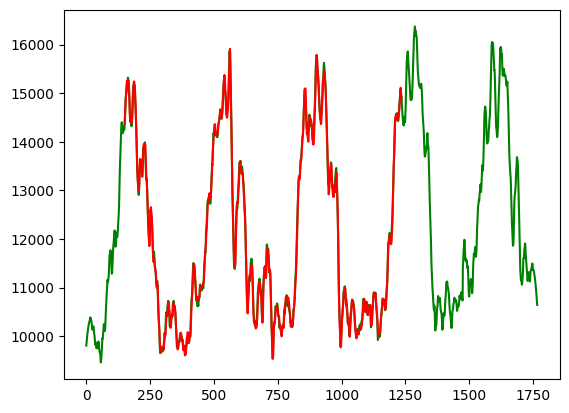

In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = np.exp(trainPredict)
trainY = scaler.inverse_transform([trainY])
trainY = np.exp(trainY)
testPredict = scaler.inverse_transform(testPredict)
testPredict = np.exp(testPredict)
testY = scaler.inverse_transform([testY])
testY = np.exp(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(np.exp(scaler.inverse_transform(dataset)), color = 'green')
plt.plot(trainPredictPlot, color = 'red')

print('testPredictions:')
print(testPredict)

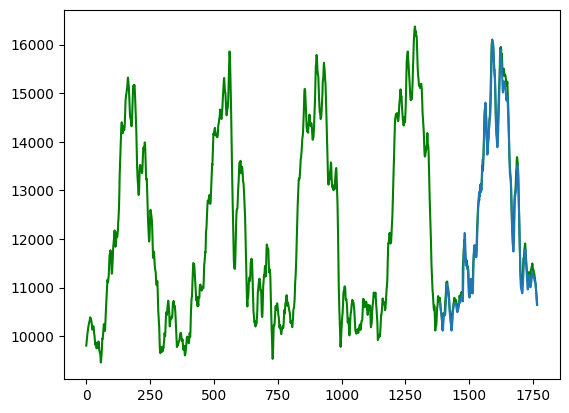

In [11]:
plt.plot(np.exp(scaler.inverse_transform(dataset)), color = 'green')
plt.plot(testPredictPlot)
plt.show()

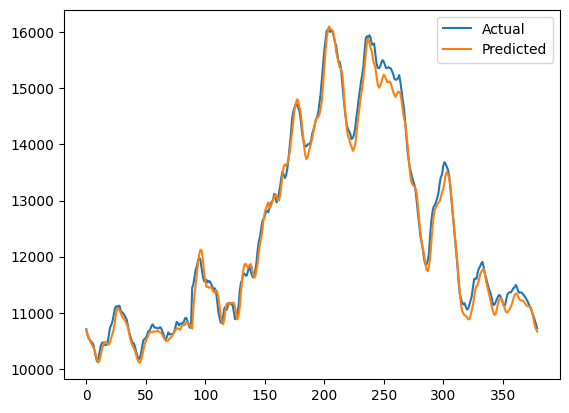

In [12]:
plt.plot(testY.flatten(), label='Actual')
plt.plot(testPredict, label='Predicted')
plt.legend()
plt.show()

In [13]:
rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE:', rmse)
mape = np.mean(np.abs((testY[0] -testPredict[:,0]) / testY[0])) * 100
print('MAPE:', mape)
r2 = r2_score(testY[0], testPredict[:,0])
print('R-squared:', r2)

def mda(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_directions = np.sum(actual_direction == predicted_direction)
    mda_value = correct_directions / (len(actual_direction) - 1)
    return mda_value

mda_value = mda(testY[0], testPredict[:,0])
print('MDA:', mda_value)

RMSE: 163.07531255010593
MAPE: 1.018086238388501
R-squared: 0.9913751245088801
MDA: 0.7804232804232805


In [14]:
# Prepare input for predicting future values
last_sequence = dataset[-look_back:]
num_predictions = 30

predicted_values = []

for _ in range(num_predictions):
    last_sequence_reshaped = np.reshape(last_sequence, (1, 1, look_back))
    predicted_value = model.predict(last_sequence_reshaped)
    predicted_values.append(predicted_value[0, 0])
    last_sequence = np.append(last_sequence[1:], predicted_value[0])

# Invert the predictions back to the original scale
predicted_values = np.exp(scaler.inverse_transform([predicted_values]))
# Print the predicted values
print(predicted_values)

1/1 [==============================] - 0s 22ms/step
[[10612.81865059 10566.14549228 10493.97788456 10402.92431951
  10317.81869286 10265.11677499 10222.58317246 10183.65506071
  10137.3993316  10071.93911204  9982.60192363  9913.80058383
   9871.87393051  9842.75795833  9821.86256969  9803.99325351
   9785.52358321  9768.95727616  9761.86055257  9762.66868433
   9779.02199025  9817.99006814  9846.70003141  9865.60158479
   9881.93276139  9905.86539303  9939.8547848   9975.78018793
  10009.25448227 10011.73076551]]


In [15]:
start_date = pandas.to_datetime(df.index[-1]) + pandas.DateOffset(days=1)  # Assuming the last date in df is the latest date
end_date = start_date + pandas.DateOffset(days=num_predictions-1)
future_dates = pandas.date_range(start=start_date, end=end_date)
predicted_values = np.reshape(predicted_values, (num_predictions,))
predicted_df = pandas.DataFrame(predicted_values, index=future_dates, columns=['Predicted'])
predicted_df

,Predicted
2021-01-01,10612.818651
2021-01-02,10566.145492
2021-01-03,10493.977885
2021-01-04,10402.924320
2021-01-05,10317.818693
2021-01-06,10265.116775
2021-01-07,10222.583172
2021-01-08,10183.655061
2021-01-09,10137.399332
2021-01-10,10071.939112


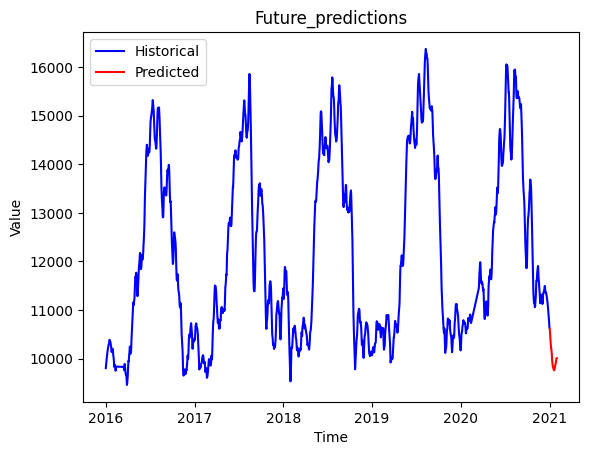

In [16]:
plt.plot(filtered_data.index, np.exp(filtered_data), color='blue', label='Historical')
plt.plot(predicted_df.index, predicted_df['Predicted'], color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Future_predictions')
plt.legend()
plt.show()

In [17]:
#model.save('C:\\Users\\Dell\\Desktop\\demand.h5')

In [18]:
def calculate_confidence_interval(predictions, standard_error, confidence_level=0.95):
    """Calculates the confidence interval for a given set of predictions.

    Args:
      predictions: A list of predictions.
      standard_error: The standard error of the predictions.
      confidence_level: The desired confidence level.

    Returns:
      A list of confidence intervals, where each confidence interval is a tuple of
      (lower bound, upper bound).
    """

    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    confidence_intervals = []

    for prediction in predictions:
        lower_bound = prediction - z_score * standard_error
        upper_bound = prediction + z_score * standard_error
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

def create_confidence_intervals_df(confidence_intervals, predicted_df):
    """
    Create a DataFrame from confidence intervals.

    Parameters:
    - confidence_intervals (list or array-like): The confidence intervals data.
    - predicted_df (DataFrame): The DataFrame with suitable index.

    Returns:
    - DataFrame: The resulting DataFrame with columns 'lower_bound' and 'upper_bound'.
    """
    dt = pandas.DataFrame(confidence_intervals, columns=['lower_bound', 'upper_bound'])
    dt.index = predicted_df.index
    return dt

In [19]:
std_p = np.std(predicted_values)
std_error = std_p/np.sqrt(num_predictions)
ci_95 = calculate_confidence_interval(predicted_df['Predicted'],std_error, 0.95)
ci_99 = calculate_confidence_interval(predicted_df['Predicted'],std_error, 0.99)
ci_90 = calculate_confidence_interval(predicted_df['Predicted'],std_error, 0.90)
ci_85 = calculate_confidence_interval(predicted_df['Predicted'],std_error, 0.85)

In [20]:
ci_95 = create_confidence_intervals_df(ci_95, predicted_df)
ci_99 = create_confidence_intervals_df(ci_99, predicted_df)
ci_90 = create_confidence_intervals_df(ci_90, predicted_df)
ci_85 = create_confidence_intervals_df(ci_85, predicted_df)

In [21]:
max_ = max(ci_99['upper_bound'])
predicted_df['Predicted'] = predicted_df['Predicted']/max_
ci_99 = ci_99/max_
ci_95 = ci_95/max_
ci_90 = ci_90/max_
ci_85 = ci_85/max_

In [22]:
# plt.plot(predicted_df.index, predicted_df['Predicted'], color='red', label='Predicted')
# plt.fill_between(dt.index, dt['lower_bound'], dt['upper_bound'], color='blue', alpha=0.5, label='95% Confidence Interval')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Future_predictions')
# plt.legend()
# plt.show()

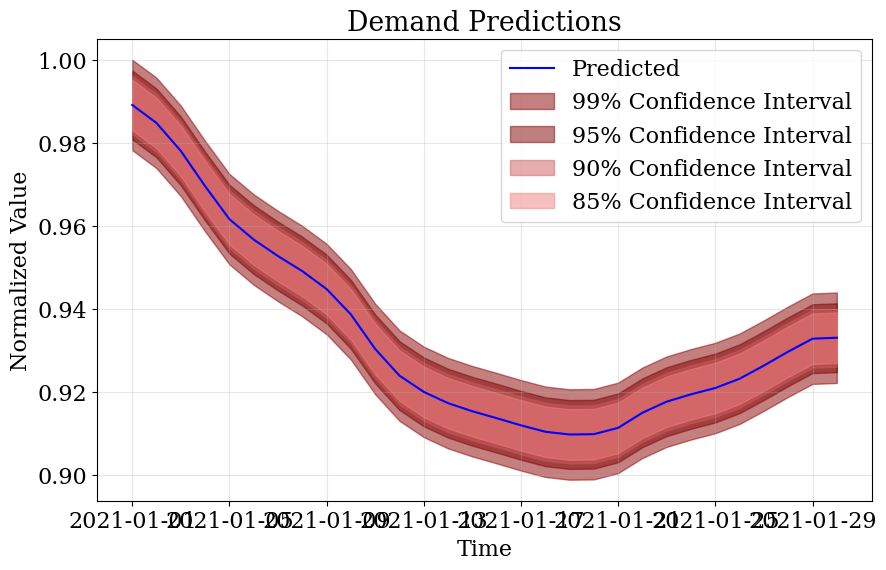

In [23]:
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(predicted_df.index, predicted_df['Predicted'], color='blue', label='Predicted')
ax.fill_between(ci_99.index, ci_99['lower_bound'], ci_99['upper_bound'], color='darkred', alpha=0.5, label='99% Confidence Interval')
ax.fill_between(ci_95.index, ci_95['lower_bound'], ci_95['upper_bound'], color='maroon', alpha=0.5, label='95% Confidence Interval')
ax.fill_between(ci_90.index, ci_90['lower_bound'], ci_90['upper_bound'], color='indianred', alpha=0.5, label='90% Confidence Interval')
ax.fill_between(ci_85.index, ci_85['lower_bound'], ci_85['upper_bound'], color='lightcoral', alpha=0.5, label='85% Confidence Interval')

# xtick_positions = np.linspace(0, 30, 30)

# plt.xticks(predicted_df.index, list(range(30)), rotation = 45)
plt.legend()
plt.title(f'Demand Predictions')
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.grid(alpha=0.3)
plt.rcdefaults()

In [24]:
# def problem(demand_ci, index_):
#     scales = TemporalScale(discretization_list=[1])
    
#     Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

#     Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

#     Power = Resource(name='Power', basis='MW', label='Power generated', demand = True, varying = [VaryingResource.UNCERTAIN_DEMAND], 
#                     varying_bounds  = (demand_ci['lower_bound'][index_],demand_ci['upper_bound'][index_]))#(min(demand['COAST']), 1))
    
#     H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

#     O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

#     H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand= True) #, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))

#     Uranium = Resource(name='Uranium', cons_max=1000,
#                    price=42.70/(250/2), basis='kg', label='Uranium')
    
#     LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  prod_max=100,
#                 storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=30)

#     WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
#                 prod_max=100, label='Wind mill array', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY], 
#                 #varying_bounds = (wind_ci['lower_bound'][index_],wind_ci['upper_bound'][index_]))

#     PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
#                 prod_max=100, label='Solar PV', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY], 
#                 # varying_bounds = (solar_ci['lower_bound'][index_],solar_ci['upper_bound'][index_]))

#     PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=0, fopex=0,
#               vopex=1.55*10**3, prod_max=100, cap_min = 0, basis = 'tons', label = 'PEM' )
    
#     ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
#                capex=7988951, fopex=0.04*0.730, vopex=7988, prod_max=100, label='Small modular reactors (SMRs)', block='power_gen')
    
#     region = Location(name='region', processes={
#                     LiI, WF, ASMR}, scales=scales, label='some region wo dispatchable')
#     scenario = Scenario(name='example', demand={region: {Power:100}}, network=region, scales=scales, label='example scenario')
#     matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)
#     # print(matrix)
#     # return matrix
#     # print(scenario.b_df)
#     print(matrix['no_eq_cons'])
#     return matrix, solve(matrix = matrix, interface = 'native', name = 'results', solver = 'ppopt') 


In [25]:
# time_periods = 3
# solution_99 =  [problem(ci_99, index_) for index_ in range(time_periods)]
# solution_95 =  [problem(ci_95, index_) for index_ in range(time_periods)]
# solution_90 =  [problem(ci_90, index_) for index_ in range(time_periods)]
# solution_85 =  [problem(ci_85, index_) for index_ in range(time_periods)]

In [26]:
from energiapy.components.scenario import Scenario
from energiapy.components.location import Location
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.material import Material
from energiapy.components.temporal_scale import TemporalScale

In [27]:
scales = TemporalScale(discretization_list=[1])

Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', label='Power generated', demand = True, varying = [VaryingResource.UNCERTAIN_DEMAND], 
                 varying_bounds  = (0,1))#(min(demand['COAST']), 1))

H2O = Resource(name='H2O', cons_max=500, basis='tons', label='Water')

O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

H2 = Resource(name='H2', basis='tons', label='Hydrogen', demand= True) #, varying = [VaryingResource.UNCERTAIN_DEMAND], varying_bounds  = (0.6, 0.8))

Uranium = Resource(name='Uranium', cons_max=1000,
                price=42.70/(250/2), basis='kg', label='Uranium')

LiI = Process(name='LiI', storage=Power, vopex=1302, capex=0, fopex=0,  prod_max=200,
            storage_loss=0.11,  label='Lithium-ion battery', basis='MW', store_max=200)

WF = Process(name='WF', conversion={Wind: -1, Power: 0.85}, vopex=990, capex=0, fopex=0,
            prod_max=100, label='Wind mill array', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY], 
            #varying_bounds = (0,1))

PV = Process(name='PV', conversion={Solar: -1, Power: 0.75}, vopex=567, capex=0, fopex=0,
            prod_max=100, label='Solar PV', basis='MW')#, varying = [VaryingProcess.UNCERTAIN_CAPACITY], 
            # varying_bounds = (solar_ci['lower_bound'][index_],solar_ci['upper_bound'][index_]))

PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, H2O: -3.1839}, capex=0, fopex=0,
            vopex=1.55*10**3, prod_max=100, cap_min = 0, basis = 'tons', label = 'PEM' )

ASMR = Process(name='ASMR', conversion={Uranium: -4.17*10**(-5), H2O: -3.364, Power: 1},
            capex=7988951, fopex=0.04*0.730, vopex=7988, prod_max=100, label='Small modular reactors (SMRs)', block='power_gen')

region = Location(name='region', processes={
                LiI, WF, ASMR}, scales=scales, label='some region wo dispatchable')
scenario = Scenario(name='example', demand={region: {Power:60}}, network=region, scales=scales, label='example scenario')
matrix = formulate(scenario=scenario, model_class=ModelClass.MPLP)
# print(matrix)
# return matrix
# print(scenario.b_df)

The problem has the following variables:
Resource inventory level (Inv) x 1
Exact resource discharge (Sf) x 0
Uncertain resource discharge (S) x 1
Exact resource availability (Af) x 3
Uncertain resource availability (A) x 0
Exact resource price (Cf) x 3
Uncertain resource price (C) x 0
Exact process production (Pf) x 4
Uncertain process production (P) x 0
 For a total of 9 (8 fixed, and 1 uncertain)


In [28]:
scenario.A_df

,Inv_LiI_Power_stored,S_Power,Af_H2O,Af_Uranium,Af_Wind,Pf_ASMR,Pf_LiI,Pf_LiI_discharge,Pf_WF
MB_H2O(=),1.0,0.0,0.0,0.0,0.0,0.000000,1.0,-1.00,0.00
MB_LiI_Power_stored(=),0.0,-1.0,0.0,0.0,0.0,1.000000,-1.0,0.89,0.85
MB_Power(=),0.0,0.0,1.0,0.0,0.0,-3.364000,0.0,0.00,0.00
MB_Uranium(=),0.0,0.0,0.0,1.0,0.0,-0.000042,0.0,0.00,0.00
MB_Wind(=),0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.00,-1.00
Inv_LiI_Power_stored(<),1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00
S_Power(>),0.0,-1.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00
Af_H2O(<),0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.00,0.00
Af_Uranium(<),0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.00,0.00
Af_Wind(<),0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.00,0.00


In [29]:
scenario.b_df

,rhs
MB_H2O(=),0.0
MB_LiI_Power_stored(=),0.0
MB_Power(=),0.0
MB_Uranium(=),0.0
MB_Wind(=),0.0
Inv_LiI_Power_stored(<),200.0
S_Power(>),0.0
Af_H2O(<),500.0
Af_Uranium(<),1000.0
Af_Wind(<),100.0


In [30]:
scenario.F_df

,Th_Power
MB_H2O(=),0.0
MB_LiI_Power_stored(=),0.0
MB_Power(=),0.0
MB_Uranium(=),0.0
MB_Wind(=),0.0
Inv_LiI_Power_stored(<),0.0
S_Power(>),-60.0
Af_H2O(<),0.0
Af_Uranium(<),0.0
Af_Wind(<),0.0


In [31]:
scenario.set_dict

{'resources': ['H2O', 'LiI_Power_stored', 'Power', 'Uranium', 'Wind'],
 'resources_nosell': ['H2O', 'LiI_Power_stored', 'Uranium', 'Wind'],
 'resources_sell': ['Power'],
 'resources_store': ['LiI_Power_stored'],
 'resources_purch': ['H2O', 'Uranium', 'Wind'],
 'resources_varying_demand': [],
 'resources_certain_demand': [],
 'resources_uncertain_demand': ['Power'],
 'resources_varying_price': [],
 'resources_certain_price': ['H2O', 'Uranium', 'Wind'],
 'resources_uncertain_price': [],
 'resources_varying_revenue': [],
 'resources_certain_revenue': [],
 'resources_uncertain_revenue': [],
 'resources_varying_availability': [],
 'resources_certain_availability': ['H2O', 'Uranium', 'Wind'],
 'resources_uncertain_availability': [],
 'resources_demand': ['Power'],
 'resources_implicit': [],
 'processes': ['ASMR', 'LiI', 'LiI_discharge', 'WF'],
 'processes_full': ['ASMR', 'LiI', 'LiI_discharge', 'WF'],
 'processes_failure': [],
 'processes_materials': ['ASMR', 'LiI', 'LiI_discharge', 'WF'],
 

In [32]:
prog = MPLP_Program(matrix['A'], matrix['b'], matrix['c'], matrix['H'],
                    matrix['CRa'], matrix['CRb'], matrix['F'], equality_indices=list(range(matrix['no_eq_cons'])))

In [33]:
matrix['A'][0][6] = -1 
matrix['A'][0][7] = 1 

In [34]:
scenario.c_df

,0
Inv_LiI_Power_stored,0.0000
S_Power,0.0000
Af_H2O,0.0000
Af_Uranium,0.3416
Af_Wind,0.0000
Pf_ASMR,7988.0000
Pf_LiI,1302.0000
Pf_LiI_discharge,0.0000
Pf_WF,990.0000


In [35]:
scenario.make_conversion_df()

,Power,Wind,LiI_Power_stored,H2O,Uranium
ASMR,1.00,0.0,0.0,-3.364,-0.000042
WF,0.85,-1.0,0.0,0.000,0.000000
LiI,-1.00,0.0,1.0,0.000,0.000000
LiI_discharge,0.89,0.0,-1.0,0.000,0.000000


In [36]:
scenario.A_df

,Inv_LiI_Power_stored,S_Power,Af_H2O,Af_Uranium,Af_Wind,Pf_ASMR,Pf_LiI,Pf_LiI_discharge,Pf_WF
MB_H2O(=),1.0,0.0,0.0,0.0,0.0,0.000000,-1.0,1.00,0.00
MB_LiI_Power_stored(=),0.0,-1.0,0.0,0.0,0.0,1.000000,-1.0,0.89,0.85
MB_Power(=),0.0,0.0,1.0,0.0,0.0,-3.364000,0.0,0.00,0.00
MB_Uranium(=),0.0,0.0,0.0,1.0,0.0,-0.000042,0.0,0.00,0.00
MB_Wind(=),0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.00,-1.00
Inv_LiI_Power_stored(<),1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00
S_Power(>),0.0,-1.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00
Af_H2O(<),0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.00,0.00
Af_Uranium(<),0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.00,0.00
Af_Wind(<),0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.00,0.00


In [37]:
time_periods = 24

In [38]:
from scipy.linalg import block_diag
A = block_diag(*[matrix['A'] for x in range(time_periods)])

In [39]:
for i in range(time_periods -1):
    x_cord = i*9
    y_cord = (i+1)*(23)
    A[y_cord, x_cord] = -1

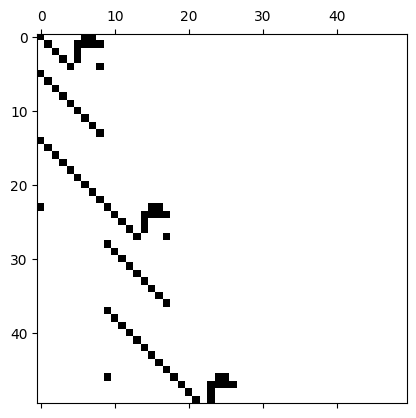

In [40]:
plt.spy(A[:50,:50])

In [41]:
c = np.vstack([matrix['c'] for _ in range(time_periods)])

In [42]:
F = np.vstack([matrix['F'] for _ in range(time_periods)])

In [43]:
b = np.vstack([matrix['b'] for _ in range(time_periods)])

In [44]:
for i in range(time_periods):
    b[23*i+13] = predicted_df.to_numpy()[i]*100

In [45]:
A_t = np.array([[1],[-1]])
b_t = np.array([[6],[0]])

In [46]:
eqs = [[0+i*23,1+i*23,2+i*23,3+i*23,4+i*23] for i in range(time_periods)]
eqs = sum(eqs, [])

In [47]:
from ppopt.mplp_program import MPLP_Program
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm

prog = MPLP_Program(A, b, c, np.zeros((1,time_periods*9)).T,
                    A_t, b_t, F, equality_indices=eqs)

In [48]:
b_t

array([[6],
       [0]])

In [49]:
prog.solver.solvers['lp'] = 'gurobi'
prog.b[0] = 20
prog.process_constraints()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19


In [50]:
for i in range(24):
    prog.c[0 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[1 + 9*i] = -10 * (1 - 0.0001)**i
    prog.c[2 + 9*i] = 10 * (1 - 0.0001)**i
    prog.c[3 + 9*i] = 10000 * (1 - 0.0001)**i
    # prog.c[4 + 9*i] = 0
    prog.c[5 + 9*i] = 100000 * (1 - 0.0001)**i
    prog.c[6 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[7 + 9*i] = 0 * (1 - 0.0001)**i
    prog.c[8 + 9*i] = 0 * (1 - 0.0001)**i

In [51]:
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm

In [52]:
prog.solve_theta(np.array([[2]])).active_set, prog.num_constraints()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 121, 125, 126, 132, 136, 140, 141, 147, 148, 151,
        155, 156, 162, 163, 166, 170, 171, 177, 178, 181, 185, 186, 192,
        193, 196, 200, 201, 207, 208, 211, 215, 216, 222, 223, 226, 230,
        231, 237, 238, 241, 245, 246, 252, 253, 256, 260, 261, 267, 268,
        271, 275, 276, 282, 283, 286, 290, 291, 297

In [53]:
prog.solve_theta(np.array([[2]])).active_set

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 121, 125, 126, 132, 136, 140, 141, 147, 148, 151,
       155, 156, 162, 163, 166, 170, 171, 177, 178, 181, 185, 186, 192,
       193, 196, 200, 201, 207, 208, 211, 215, 216, 222, 223, 226, 230,
       231, 237, 238, 241, 245, 246, 252, 253, 256, 260, 261, 267, 268,
       271, 275, 276, 282, 283, 286, 290, 291, 297, 298, 301, 30

In [54]:
from ppopt.utils.constraint_utilities import is_full_rank

is_full_rank(prog.A[prog.equality_indices])

True

In [55]:
theta = np.linspace(0.0001, 5.9999, 100)

In [56]:
sols = [prog.solve_theta(np.array([[t]])) for t in theta]
sols_obj = [sol.obj.flatten() for sol in sols if sol is not None]

In [57]:
#plt.plot(theta, sols_obj)

In [58]:
x = prog.solve_theta(np.array([[2]]))

In [59]:
count = 0
for index, i in enumerate(x.dual):
    if not np.isclose(i, 0):
        count += 1
print(count)

192


In [60]:
sol2 = prog.solve_theta(np.array([[2]]))
sol3 = prog.solve_theta(np.array([[2]]))

In [61]:
sol0 = prog.solve_theta(np.array([[0]]))

In [62]:
A = sol3.sol - sol2.sol
b = sol0.sol

In [63]:
A[:9]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [64]:
prog.c.T@(b + A*6)

array([-19240.4700365])

In [65]:
prog.c[:9]

array([[ 0.e+00],
       [-1.e+01],
       [ 1.e+01],
       [ 1.e+04],
       [ 0.e+00],
       [ 1.e+05],
       [ 0.e+00],
       [ 0.e+00],
       [ 0.e+00]])

In [ ]:
sol3 = prog.solve_theta(np.array([[2.9]]))
# sol3 = prog.solve_theta(numpy.array([[0.1]]))


# time_sols = sol3.sol.reshape(24, -1)
# plt.subplots(figsize=(20, 10))
# labels = ['Inv','Sale of Power','Cons. H20','Cons. U','Cons. Wind','Prod. Nucluer','Prod. LiIon','Prod. LiIon Discharch','Prod. Windfarm']
# for i in range(9):
#     plt.plot(list(range(24)), time_sols[:,i])
# plt.legend(labels)
# plt.savefig('baba.pdf')

# plt.subplots(figsize=(20, 10))
time_sols = sol3.sol.reshape(24, -1)
labels = ['Inv Power','S Power','C H2O','C Ur','C Wind','P SMR','P LiI',r'P LiI$_d$','P WF']
lines = ['dotted', 'dashed', 'solid','solid', 'solid', 'dashdot', 'dashdot', 'dashdot', 'dashdot']
annot = ['', '', 'H2O', 'Ur', 'Wind', 'SMR', 'LiI', 'LiI_d', 'WF']
# for i in range(9):
#     plt.plot(list(range(24)), time_sols[:,i])
# plt.legend(labels)

# plt.savefig('baba_nominal.pdf')
from matplotlib import rc
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(normalize(obj3), normalize(obj4), s=10, color='steelblue')
for i in range(9):
    ax.plot(list(range(24)), time_sols[:,i], label=labels[i], linestyle = lines[i])
    # ax.annotate(annot[i], xy = (23, time_sols[:,i][23]))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
      fancybox=True, shadow=True, ncol=5)

# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
# ax.set_xticklabels(list(range(24)))

# xtick_positions = np.linspace(0, 24, 24)

# plt.xticks(list(range(24)), list(range(24)), rotation = 45)
# plt.legend()
plt.title(f'Robust Schedule')
plt.xlabel("Hour")
plt.ylabel("Amount")
plt.grid(alpha=0.3)
plt.rcdefaults()
plt.tight_layout()
plt.savefig('baba_6.pdf')
plt.savefig('baba_6.png', dpi = 400)